In [81]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy
import time
from theano.tensor.signal import downsample
import numpy as np
import pylab
from PIL import Image
from Data import Load

In [82]:
rng = numpy.random.RandomState(23455)

# instantiate 4D tensor for input
input = T.tensor4(name='input')

# initialize shared variable for weights.
w_shp = (2, 1, 9, 9)
w_bound = numpy.sqrt(1 * 9 * 9)
W = theano.shared( numpy.asarray(
            rng.uniform(
                low=-1.0 / w_bound,
                high=1.0 / w_bound,
                size=w_shp),
            dtype=input.dtype), name ='W')

# initialize shared variable for bias (1D tensor) with random values
# IMPORTANT: biases are usually initialized to zero. However in this
# particular application, we simply apply the convolutional layer to
# an image without learning the parameters. We therefore initialize
# them to random values to "simulate" learning.
b_shp = (2,)
b = theano.shared(numpy.asarray(
            rng.uniform(low=-.5, high=.5, size=b_shp),
            dtype=input.dtype), name ='b')

# build symbolic expression that computes the convolution of input with filters in w
conv_out = conv2d(input, W)

# build symbolic expression to add bias and apply activation function, i.e. produce neural net layer output
# A few words on ``dimshuffle`` :
#   ``dimshuffle`` is a powerful tool in reshaping a tensor;
#   what it allows you to do is to shuffle dimension around
#   but also to insert new ones along which the tensor will be
#   broadcastable;
#   dimshuffle('x', 2, 'x', 0, 1)
#   This will work on 3d tensors with no broadcastable
#   dimensions. The first dimension will be broadcastable,
#   then we will have the third dimension of the input tensor as
#   the second of the resulting tensor, etc. If the tensor has
#   shape (20, 30, 40), the resulting tensor will have dimensions
#   (1, 40, 1, 20, 30). (AxBxC tensor is mapped to 1xCx1xAxB tensor)
#   More examples:
#    dimshuffle('x') -> make a 0d (scalar) into a 1d vector
#    dimshuffle(0, 1) -> identity
#    dimshuffle(1, 0) -> inverts the first and second dimensions
#    dimshuffle('x', 0) -> make a row out of a 1d vector (N to 1xN)
#    dimshuffle(0, 'x') -> make a column out of a 1d vector (N to Nx1)
#    dimshuffle(2, 0, 1) -> AxBxC to CxAxB
#    dimshuffle(0, 'x', 1) -> AxB to Ax1xB
#    dimshuffle(1, 'x', 0) -> AxB to Bx1xA
output = T.nnet.sigmoid(conv_out + b.dimshuffle('x', 0, 'x', 'x'))

# create theano function to compute filtered images
my_f = theano.function(inputs=[input], outputs=output)

In [83]:
all_X, all_Y = Load.load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Image shape:  (96, 96)
('filtered image shape: ', (1, 2, 88, 88))


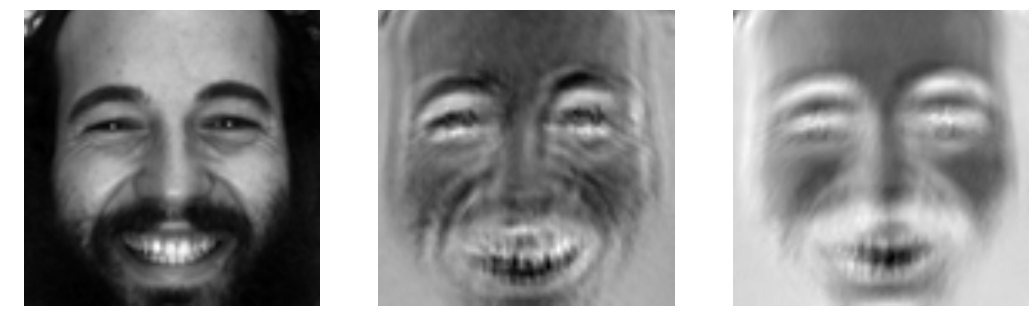

In [84]:
img_ = all_X[0].reshape(1, 1, 96, 96)
img_ = all_X[0].reshape(-1, 1, 96, 96)
print 'Image shape: ', img.shape

filtered_img = my_f(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :])
pylab.subplot(1, 3, 3); pylab.axis('off'); pylab.imshow(filtered_img[0, 1, :, :])
pylab.show()

In [86]:
input = T.dtensor4('input')
maxpool_shape = (2, 2)
pool_out = downsample.max_pool_2d(input, maxpool_shape, ignore_border=True)
f = theano.function([input],pool_out)

invals = numpy.random.RandomState(1).rand(3, 2, 5, 5)
print 'With ignore_border set to True:'
print 'invals[0, 0, :, :] =\n', invals[0, 0, :, :]
print 'output[0, 0, :, :] =\n', f(invals)[0, 0, :, :]

pool_out = downsample.max_pool_2d(input, maxpool_shape, ignore_border=False)
f = theano.function([input],pool_out)
print 'With ignore_border set to False:'
print 'invals[1, 0, :, :] =\n ', invals[1, 0, :, :]
print 'output[1, 0, :, :] =\n ', f(invals)[1, 0, :, :]

With ignore_border set to True:
invals[0, 0, :, :] =
[[  4.17022005e-01   7.20324493e-01   1.14374817e-04   3.02332573e-01
    1.46755891e-01]
 [  9.23385948e-02   1.86260211e-01   3.45560727e-01   3.96767474e-01
    5.38816734e-01]
 [  4.19194514e-01   6.85219500e-01   2.04452250e-01   8.78117436e-01
    2.73875932e-02]
 [  6.70467510e-01   4.17304802e-01   5.58689828e-01   1.40386939e-01
    1.98101489e-01]
 [  8.00744569e-01   9.68261576e-01   3.13424178e-01   6.92322616e-01
    8.76389152e-01]]
output[0, 0, :, :] =
[[ 0.72032449  0.39676747]
 [ 0.6852195   0.87811744]]
With ignore_border set to False:
invals[1, 0, :, :] =
  [[ 0.01936696  0.67883553  0.21162812  0.26554666  0.49157316]
 [ 0.05336255  0.57411761  0.14672857  0.58930554  0.69975836]
 [ 0.10233443  0.41405599  0.69440016  0.41417927  0.04995346]
 [ 0.53589641  0.66379465  0.51488911  0.94459476  0.58655504]
 [ 0.90340192  0.1374747   0.13927635  0.80739129  0.39767684]]
output[1, 0, :, :] =
  [[ 0.67883553  0.58930554

In [87]:
# Implement dropout using a binomial distribution according to the parameters of the call
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2), p_drop =.2):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape#,
            #input_shape=image_shape
        )

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = dropout(T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x')), p_drop)

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

# Implement statistical dropout
def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

# Implement rectifier activation
def rectify(X):
    return T.maximum(X, 0.)

# Initialize the weights of our NN using a normal distribution.
def init_weights(name, shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01), name)

# Stochastic gradient descent
def sgd(cost, w, lr=0.01):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * lr])
    return updates

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

In [88]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh, p_drop=.5):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        
        if W is None:
            W = init_weights("w_h", (n_in, n_out))

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)
            
        self.W = W
        self.b = b
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            dropout(lin_output, p_drop) if activation is None
            else dropout(activation(lin_output), p_drop)
        )

In [89]:
class RegressionLayer(object):
    """Multi-feature Linear Regression Class

    The linear regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a least cost fit.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the linear regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        # start-snippet-1
        # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
        self.W = init_weights("w_o", (n_in, n_out))
        
        
        # initialize the biases b as a vector of n_out 0s
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )
        
        # symbolic expression for computing the matrix of class-membership
        # probabilities
        # Where:
        # W is a matrix where column-k represent the separation hyperplane for
        # class-k
        # x is a matrix where row-j  represents input training sample-j
        # b is a vector where element-k represent the free parameter of
        # hyperplane-k
        self.y_pred = T.dot(input, self.W) + self.b

        # parameters of the model
        self.params = [self.W, self.b]
        #self.params = [self.W]

        # keep track of model input
        self.input = input
    
    def cost(self, y):
        return ((y - self.y_pred)**2).mean()
        

In [90]:
x = T.matrix('x')   # the data is presented as rasterized images
y = T.matrix('y')  # the labels are presented as a matrix of
                    # facial feature locations

# Dropout probablitites through the NN
p_drop_convo = .2
p_drop_back_nn = .5

# Learning rate
learning_rate = .001

# Define the minibatch size
miniBatchSize = 1

# Define the number of kernels on layer 0 and 1 of the convolution
nkerns=[20, 50]

rng = numpy.random.RandomState(1234)
srng = RandomStreams()

######################
# BUILD ACTUAL MODEL #
######################
print('... building the model')

# Reshape matrix of rasterized images of shape (miniBatchSize, 96 * 96)
# to a 4D tensor, compatible with our LeNetConvPoolLayer
# (96, 96) is the size of MNIST images.
#layer0_input = x.reshape((miniBatchSize, 1, 96, 96))
layer0_input = x.reshape((-1, 1, 96, 96))

# Construct the first convolutional pooling layer:
# filtering reduces the image size to (96-9+1 , 96-9+1) = (88, 88)
# maxpooling reduces this further to (88/2, 88/2) = (44, 44)
# 4D output tensor is thus of shape (miniBatchSize, nkerns[0], 88, 88)
layer0 = LeNetConvPoolLayer(
    rng,
    input=layer0_input,
    image_shape=(miniBatchSize, 1, 96, 96),
    filter_shape=(nkerns[0], 1, 9, 9),
    poolsize=(2, 2),
    p_drop = p_drop_convo
)

# Construct the second convolutional pooling layer
# filtering reduces the image size to (44-9+1, 44-9+1) = (36, 36)
# maxpooling reduces this further to (36/2, 26/2) = (18, 18)
# 4D output tensor is thus of shape (miniBatchSize, nkerns[1], 18, 18)
layer1 = LeNetConvPoolLayer(
    rng,
    input=layer0.output,
    image_shape=(miniBatchSize, nkerns[0], 44, 44),
    filter_shape=(nkerns[1], nkerns[0], 9, 9),
    poolsize=(2, 2),
    p_drop = p_drop_convo
)

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (miniBatchSize, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (miniBatchSizebatch_size, nkerns[1] * 18 * 18),
# or (500, 50 * 18 * 18) = (500, 16200) with the default values.
layer2_input = layer1.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(
    rng,
    input=layer2_input,
    n_in=nkerns[1] * 18 * 18,
    n_out=500,
    activation=rectify, p_drop = p_drop_back_nn
)

# classify the values of the fully-connected sigmoidal layer
layer3 = RegressionLayer(input=layer2.output, n_in=500, n_out=30)

# the cost we minimize during training is the NLL of the model
cost = layer3.cost(y)

# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

updates = sgd(cost, params, lr=learning_rate)

train = theano.function(inputs=[x, y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[x], outputs=layer3.y_pred, allow_input_downcast=True)

... building the model


In [91]:
# Implement stochastic gradient descent with a configurabe batch size and number of epochs

trX = all_X[:1800]
trY = all_Y[:1800]
deX = all_X[1800:]
deY = all_Y[1800:]

def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
            cost = train(trX[start:end], trY[start:end])
        pdeY = predict(deX)
        cost_de = ((deY - pdeY)**2).mean()
        print '%d) precision=%.4f, Traning cost=%.4f, DE cost: %.4f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)

gradientDescentStochastic(1) 

print 'Mean squared error on Training data: %.4f\n'%((trY - trY.mean())**2).mean()
print 'Mean squared error on Dev data: %.4f\n'%((deY - deY.mean())**2).mean()

1) precision=0.0000, Traning cost=0.0241, DE cost: 0.0163
train time = 1298.17
Mean squared error on Training data: 0.1533

Mean squared error on Dev data: 0.1569

